# Classificação de dígitos usando o modelo logístico

Implementaremos um loop completo de treinamento que será referência para todos os treinamentos futuros da disciplina!

In [1]:
import matplotlib.pyplot as plt
import torch
from dataset import load_mnist
from IPython import display
from torch import nn
from torch.utils.data import DataLoader

ds_train, ds_valid = load_mnist()

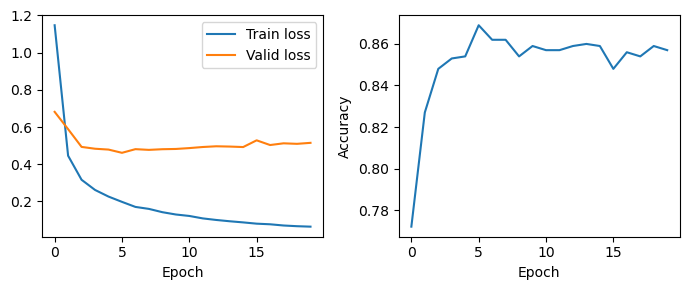

In [ ]:
class Model(nn.Module):
    """Modelo com uma camada linear."""
    def __init__(self):
        super().__init__()
        self.layer = nn.Linear(28*28, 10)
        
    def forward(self, x):
        # Cada batch é um tensor de tamanho bsx1x28x28, redimensionamos para bsx768
        x = x.reshape(x.shape[0], -1)
        return self.layer(x)
    
def train_step(model, dl_train, optim, loss_func):
    """Executa uma época de treinamento. Note que o termo `step` no nome
    da função não se refere a um passo de atualização de parâmetros, como
    estávamoss fazendo até o momento. Nesta função são feitas várias 
    atualizações, uma para cada batch."""

    # Coloca o modelo em modo treinamento. Neste notebook não fará diferença,
    # mas algumas camadas (batchnorm, dropout) precisam disso
    model.train()
    # Armazenará a média das losses de todos os bathces
    loss_log = 0.
    for imgs, targets in dl_train:
        optim.zero_grad()
        scores = model(imgs)
        loss = loss_func(scores, targets)
        loss.backward()
        optim.step()
        
        # Multiplica por batch_size porque o último batch pode ter tamanho diferente
        loss_log += loss.detach()*imgs.shape[0]

    # Média das losses calculadas
    loss_log /= len(dl_train.dataset)

    return loss_log.item()

def accuracy(scores, targets):
    return (scores.argmax(dim=1)==targets).float().mean()

# Anotador para evitar que gradientes sejam registrados dentro da função
@torch.no_grad()
def valid_step(model, dl_valid, loss_func, perf_func):

    # Coloca o modelo em modo de validação. 
    model.eval()
    # Variáveis que armazenarão a loss e a acurácia
    loss_log = 0.
    perf_log = 0.
    for imgs, targets in dl_valid:
        scores = model(imgs)
        loss = loss_func(scores, targets)
        perf = perf_func(scores, targets)

        # Multiplica por batch_size porque o último batch pode ter tamanho diferente
        loss_log += loss*imgs.shape[0]
        perf_log += perf*imgs.shape[0]

    # Média dos valores calculados
    loss_log /= len(dl_valid.dataset)
    perf_log /= len(dl_valid.dataset)

    return loss_log.item(), perf_log.item()

def show_log(logger):

    epochs, losses_train, losses_valid, accs = zip(*logger)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7,3))
    ax1.plot(epochs, losses_train, label="Train loss")
    ax1.plot(epochs, losses_valid, label="Valid loss")
    ax1.set_xlabel("Epoch")
    ax1.legend()
    ax2.plot(epochs, accs)
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Accuracy")
    fig.tight_layout()

    display.clear_output(wait=True) 
    plt.show()

def train(model, ds_train, ds_valid, bs, num_epochs, lr, perf_func):

    dl_train = DataLoader(ds_train, batch_size=bs, shuffle=True)
    dl_valid = DataLoader(ds_valid, batch_size=bs, shuffle=False)

    loss_func = nn.CrossEntropyLoss()
    optim = torch.optim.SGD(model.parameters(), lr=lr)
    logger = []
    for epoch in range(0, num_epochs):
        loss_train = train_step(model, dl_train, optim, loss_func)
        loss_valid, perf = valid_step(model, dl_valid, loss_func, perf_func)
        logger.append((epoch, loss_train, loss_valid, perf))
        show_log(logger)
    
    return logger

model = Model()
logger = train(model, ds_train, ds_valid, bs=64, num_epochs=20, lr=0.1, perf_func=accuracy)

### Interpretação dos pesos

Podemos visualizar os pesos da rede como imagens. A camada linear que treinamos possui 10 linhas e 28\*28 colunas. Cada linha i pode ser interpretada como uma função que recebe 28\*28 valores de entrada e realiza uma soma ponderada desses valores para verificar se a imagem pertence à classe i. Portanto, cada valor de uma linha i pode ser considerado como sendo o peso que a rede atribui a cada pixel ao classificar a imagem na classe i

In [3]:
print(model.layer.weight.shape)

torch.Size([10, 784])


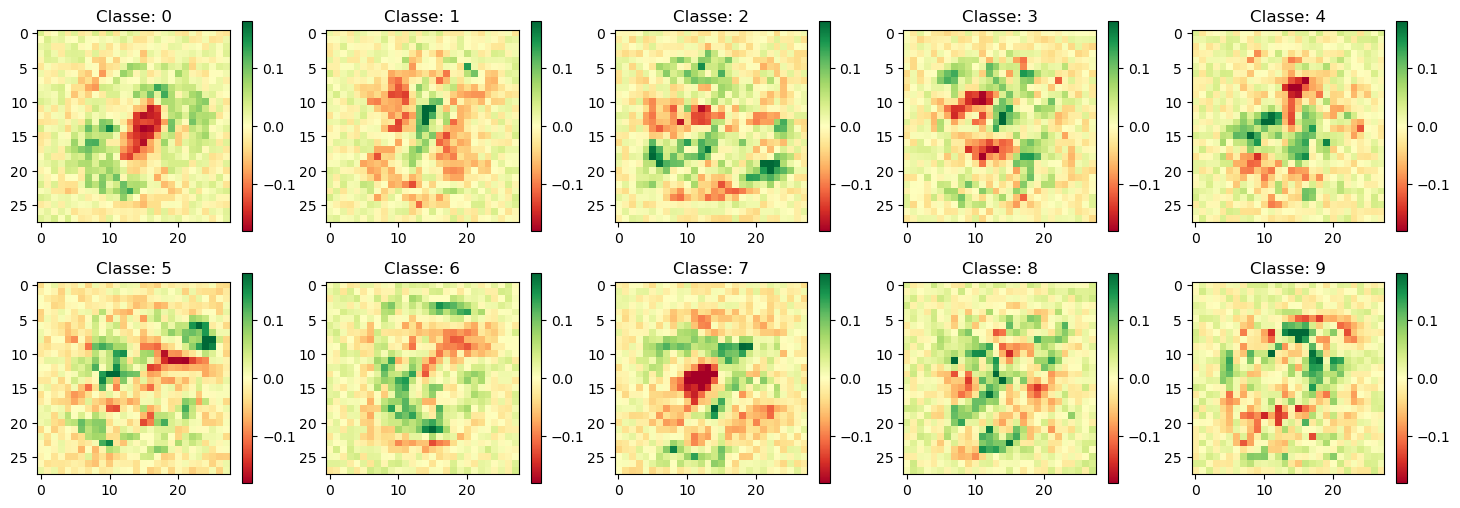

In [4]:
# Mapeia os valores de forma que o valor 0 seja o centro do mapa de cores
cn = plt.matplotlib.colors.CenteredNorm()

fig, axs = plt.subplots(2, 5, figsize=(18, 6))
axs = axs.reshape(-1)
for idx in range(10):
    # Redimensiona os pesos para uma imagem 28x28
    weight = model.layer.weight[idx].detach().reshape(28,28)
    ax = axs[idx]
    plot = ax.imshow(weight, "RdYlGn", norm=cn)
    ax.set_title(f"Classe: {idx}")
    fig.colorbar(plot, ax=ax)   

Considere por exemplo a classe 0. A imagem acima mostra que se a imagem possuir valores altos no centro a rede retorna um valor bem negativo para a classe 0. No caso da classe 1, valores altos no centro aumentam a chance da imagem ser classificada como 1.

### Usando scikit-learn

Apenas para efeito ilustrativo. Vamos fazer o mesmo treinamento usando a biblioteca scikit-learn

In [5]:
import numpy as np
from sklearn.linear_model import SGDClassifier

# Para o scikit-learn precisamos ter como entrada uma única matriz de treinamento
# e validação
data_train = np.stack([x[0] for x in ds_train]).reshape(len(ds_train), -1)
labels_train = np.array([x[1] for x in ds_train])

data_valid = np.stack([x[0] for x in ds_valid]).reshape(len(ds_train), -1)
labels_valid = np.array([x[1] for x in ds_valid])

sgd = SGDClassifier(loss="log_loss", penalty=None, 
                max_iter=100, 
                learning_rate="constant", eta0=0.01)
sgd.fit(data_train, labels_train)
print(sgd.score(data_train, labels_train))
print(sgd.score(data_valid, labels_valid))

1.0
0.836
